## 3. Ensemble-based models to predict age
We are interested in predicting age using samples from blood and their projection into the latent spaces you generated before. Note that age is a subject attribute (look at the assignment 2 for more details on how to obtain this data).

Use at least two ensemble approaches to predict age, ensuring that you are predicting a continuous variable (not a categorical one).
Use a model evaluation strategy that allows you to play with different hyperparameters to select the best model, assess whether the models are good predictors and whether they generalize well on unseen data.

### Import data and load packages

In [38]:
# import packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
import umap 
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [39]:
# Set up cross-validation with a fixed random_state
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
# import data from assignment 02 (contains age, sex and gene data for blood samples (that's z-score normalized))
GTEx_data = pd.read_csv("../02_GTEx_sm_data.csv")

In [41]:
print(GTEx_data.columns)

Index(['ENSG00000268903.1', 'ENSG00000269981.1', 'ENSG00000225972.1',
       'ENSG00000225630.1', 'ENSG00000237973.1', 'ENSG00000229344.1',
       'ENSG00000248527.1', 'ENSG00000198744.5', 'ENSG00000188976.10',
       'ENSG00000187608.8',
       ...
       'ENSG00000198899.2', 'ENSG00000198938.2', 'ENSG00000198840.2',
       'ENSG00000212907.2', 'ENSG00000198886.2', 'ENSG00000198786.2',
       'ENSG00000198695.2', 'ENSG00000198727.2', 'SEX_f', 'AGE_f'],
      dtype='object', length=5002)


### Set up metadata into labels for age

In [42]:
# drop the SEX_f column 
GTEx_data = GTEx_data.drop('SEX_f', axis = 1)
# pop out AGE col 
GTEx_age = GTEx_data.pop('AGE_f')
print(GTEx_age.shape)
print(GTEx_data.shape)

(929,)
(929, 5000)


In [43]:
# set up GTEx_age into a discrete numeric variable 
print(GTEx_age.unique())
# binned ages, convert to numeric
# take the starting number of the binds
# Extract the starting number of the age range (the part before the '-')
GTEx_age = GTEx_age.str.split('-').str[0].astype(int)
print(GTEx_age.unique())

['60-69' '50-59' '40-49' '20-29' '30-39' '70-79']
[60 50 40 20 30 70]


#### Dimension Reduction

In [44]:
# set up PCA of GTEx data based on best parameters from 01_dimension_reduction
# reduce GTEx data to a PCA of 40 dimensions, considered best
pca = PCA(n_components=40)
pca_fit = pca.fit(GTEx_data)
pca_data = pca_fit.transform(GTEx_data)

In [45]:
# set up UMAP of GTEx data based on best parameters from 01_dimension_reduction
# reduce data with UMAP, set seed because stochastic
umap = umap.UMAP(random_state=42, n_components=200, min_dist=0.1, n_neighbors=50)
umap_fit = umap.fit(GTEx_data) 
umap_data = umap_fit.transform(GTEx_data) 

/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/projects/kterwelp@xsede.org/software/anaconda/envs/cpbs7602_assignment03/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


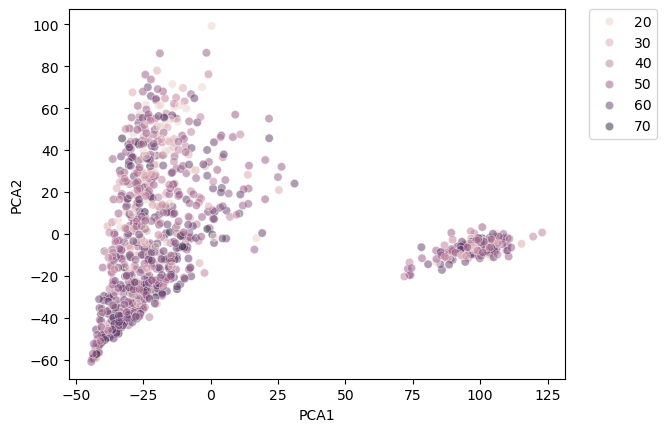

In [46]:
pca_df = pd.DataFrame({
    "PCA1": pca_data[:, 0],
    "PCA2": pca_data[:, 1],
    "Age": GTEx_age,
    "label": GTEx_age
})
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Age", data=pca_df, alpha = 0.5)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

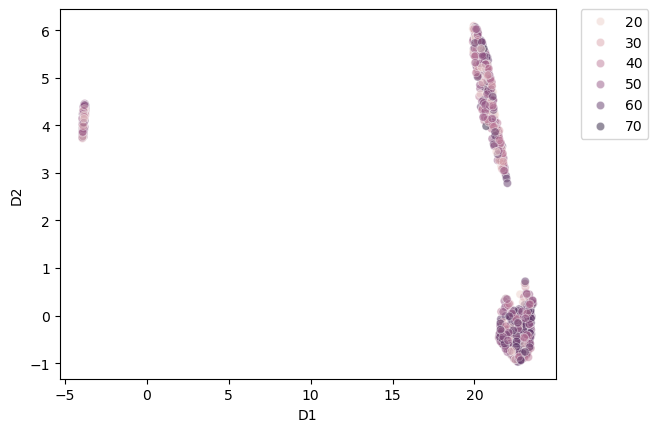

In [15]:
umap_df = pd.DataFrame({
    "D1": umap_data[:, 0],
    "D2": umap_data[:, 1],
    "Age": GTEx_age,
    "label": GTEx_age
})
ax = sns.scatterplot(x="D1", y="D2", hue="Age", data=umap_df, alpha = 0.5)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The PCA/UMAP data appears to be separating the data into distinct clusters that are intermixed with various ages.

### Set up validation and test/train datasets

In [47]:
# train datasets will be used in parameter tuning which will be done with cross-folds validation. 
# test datasets will be used on the final tuned model to evaluate how generalizable it is.

# both pca and umap use the same seed, so will have the same split of samples 

PCA_train, PCA_test, UMAP_train, UMAP_test, y_train, y_test = train_test_split(
    pca_data, umap_data, GTEx_age, test_size=0.20, random_state=42)


In [48]:
print(f"Training sample size: {PCA_train.shape[0]}")
print(f"Test sample size: {PCA_test.shape[0]}")
print(f"Number of features of PCA: {PCA_train.shape[1]}")
print(f"Number of features of UMAP: {UMAP_train.shape[1]}")

Training sample size: 743
Test sample size: 186
Number of features of PCA: 40
Number of features of UMAP: 200


### Ensemble Modeling

#### Weak Learners: Boosting with Gradient Boosting

##### Step One: Parameter Optimization with RandomizedSearchCV

In [50]:
# result of no parameter tuning: 
clf = HistGradientBoostingRegressor(random_state=30)
cv_score = cross_val_score(clf, PCA_train, y_train, cv=cv, scoring="r2")
print(cv_score.mean())
cv2_score = cross_val_score(clf, UMAP_train, y_train, cv=cv, scoring="r2")
print(cv2_score.mean())

0.07033527646857478
-0.03944719170221089


These are terrible, somehow the UMAP is performing worse than mean?

In [51]:
# test learning_rate for UMAP
clf = HistGradientBoostingRegressor(random_state=30, early_stopping=True, max_iter=1000)
param_grid = {
    'learning_rate': np.linspace(0.005, 1, num=200), 

}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"PCA Best learning rate: {grid_search.best_params_['learning_rate']}")
print(f"PCA Best cross-validation score: {grid_search.best_score_}")

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print(f"UMAP Best learning rate: {grid_search.best_params_['learning_rate']}")
print(f"UMAP Best cross-validation score: {grid_search.best_score_}")


PCA Best learning rate: 0.065
PCA Best cross-validation score: 0.10372846859732007
UMAP Best learning rate: 0.025
UMAP Best cross-validation score: 0.08190727234486042


In [54]:
param_grid = {
    'max_iter': np.arange(20, 80, 10), 
    'max_depth': np.arange(2, 21, 2), 
    'max_leaf_nodes': [10, 20, 40, 100],
    'max_features': [0.2, 0.4, 0.8, 0.9]
}
clf = HistGradientBoostingRegressor(random_state=30, learning_rate=0.065)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"PCA Best max iter: {grid_search.best_params_['max_iter']}")
print(f"PCA Best max depth: {grid_search.best_params_['max_depth']}")
print(f"PCA Best max leaf nodes: {grid_search.best_params_['max_leaf_nodes']}")
print(f"PCA Best max features : {grid_search.best_params_['max_features']}")
print(f"PCA Best cross-validation score: {grid_search.best_score_}")

clf = HistGradientBoostingRegressor(random_state=30, learning_rate=0.025)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print(f"UMAP Best max iter: {grid_search.best_params_['max_iter']}")
print(f"UMAP Best max depth: {grid_search.best_params_['max_depth']}")
print(f"UMAP Best max leaf nodes: {grid_search.best_params_['max_leaf_nodes']}")
print(f"UMAP Best max features : {grid_search.best_params_['max_features']}")
print(f"UMAP Best cross-validation score: {grid_search.best_score_}")

PCA Best max iter: 30
PCA Best max depth: 10
PCA Best max leaf nodes: 40
PCA Best max features : 0.4
PCA Best cross-validation score: 0.15276621455180062
UMAP Best max iter: 60
UMAP Best max depth: 8
UMAP Best max leaf nodes: 10
UMAP Best max features : 0.4
UMAP Best cross-validation score: 0.12018848907897801


##### Testing Models on Unseen Data

In [55]:
# best models after testing parameters
pca_model = HistGradientBoostingRegressor(random_state=30, learning_rate=0.065, max_iter=30, max_depth=10, max_leaf_nodes=40, max_features=0.4)
umap_model = HistGradientBoostingRegressor(random_state=30, learning_rate=0.025, max_iter=60, max_depth=8, max_leaf_nodes=10, max_features=0.4)

# fit models 
pca_model.fit(PCA_train, y_train)
umap_model.fit(UMAP_train, y_train)

# evaluate models on unseen data
pca_predicts = pca_model.predict(PCA_test)

umap_predicts = umap_model.predict(UMAP_test)

# Print additional metrics for PCA model
print("PCA model evaluation:")
mae_pca = mean_absolute_error(y_test, pca_predicts)
mse_pca = mean_squared_error(y_test, pca_predicts)
rmse_pca = np.sqrt(mse_pca)
r2_pca = r2_score(y_test, pca_predicts)

print(f"Mean Absolute Error (MAE): {mae_pca:.4f}")
print(f"Mean Squared Error (MSE): {mse_pca:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_pca:.4f}")
print(f"R-squared (R²): {r2_pca:.4f}")

# Print additional metrics for UMAP model
print("UMAP model evaluation:")
mae_umap = mean_absolute_error(y_test, umap_predicts)
mse_umap = mean_squared_error(y_test, umap_predicts)
rmse_umap = np.sqrt(mse_umap)
r2_umap = r2_score(y_test, umap_predicts)

print(f"Mean Absolute Error (MAE): {mae_umap:.4f}")
print(f"Mean Squared Error (MSE): {mse_umap:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_umap:.4f}")
print(f"R-squared (R²): {r2_umap:.4f}")

PCA model evaluation:
Mean Absolute Error (MAE): 10.2855
Mean Squared Error (MSE): 160.6376
Root Mean Squared Error (RMSE): 12.6743
R-squared (R²): 0.1163
UMAP model evaluation:
Mean Absolute Error (MAE): 10.2274
Mean Squared Error (MSE): 166.0445
Root Mean Squared Error (RMSE): 12.8858
R-squared (R²): 0.0866


PCA continues to outperform the UMAP model. However, both do atrocious with R2 values under 10% variance explained by model. 

### Bagging: Random Forest Regressor

#### Parameter Tuning

In [56]:
# result of no parameter tuning: 
clf = RandomForestRegressor(random_state=30)
cv_score = cross_val_score(clf, PCA_train, y_train, cv=cv, scoring='r2')
print(cv_score.mean())
cv2_score = cross_val_score(clf, UMAP_train, y_train, cv=cv, scoring='r2')
print(cv2_score.mean())

0.11335821300614073
0.06022934050267106


Base random forest regressor already outperforms most of the hist boosting models 

In [57]:
# adjusting n_estimators and max_features
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features}

In [58]:
clf = RandomForestRegressor(random_state=30)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"Best n estimators for PCA: {grid_search.best_params_['n_estimators']}")
print(f"Best max_features for PCA: {grid_search.best_params_['max_features']}")
print(f"Best cross-validation score for PCA: {grid_search.best_score_}")


clf = RandomForestRegressor(random_state=30)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print(f"Best n estimators for UMAP: {grid_search.best_params_['n_estimators']}")
print(f"Best max_features for UMAP: {grid_search.best_params_['max_features']}")
print(f"Best cross-validation score for UMAP: {grid_search.best_score_}")

Best n estimators for PCA: 800
Best max_features for PCA: sqrt
Best cross-validation score for PCA: 0.12625276634410248
Best n estimators for UMAP: 1400
Best max_features for UMAP: log2
Best cross-validation score for UMAP: 0.08295930458345735


In [59]:
# Max depth tuning
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Number of features to consider at every split
max_features = ['sqrt', 'log2']

# Create the param grid
param_grid = {
    'max_depth': max_depth
    }

In [60]:
clf = RandomForestRegressor(random_state=30, n_estimators=800, max_features="sqrt")
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"Best max_depth for PCA: {grid_search.best_params_['max_depth']}")
print(f"Best cross-validation score for PCA: {grid_search.best_score_}")

clf = RandomForestRegressor(random_state=30, n_estimators=1400, max_features="log2")
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"Best max_depth for PCA: {grid_search.best_params_['max_depth']}")
print(f"Best cross-validation score for PCA: {grid_search.best_score_}")

Best max_depth for PCA: 30
Best cross-validation score for PCA: 0.12625276634410248
Best max_depth for PCA: 40
Best cross-validation score for PCA: 0.12306087540128466


In [61]:
# adjusting min_samples_split and min_samples_leaf
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64]
param_grid = {'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

In [62]:
clf = RandomForestRegressor(random_state=30, n_estimators=1800, max_features="sqrt", max_depth=30)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(PCA_train, y_train)
print(f"Best min samples split for PCA: {grid_search.best_params_['min_samples_split']}")
print(f"Best min samples leaf for PCA: {grid_search.best_params_['min_samples_leaf']}")
print(f"Best cross-validation score for PCA: {grid_search.best_score_}")


clf = RandomForestRegressor(random_state=30, n_estimators=1400, max_features="log2", max_depth=40)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(UMAP_train, y_train)
print(f"Best min samples split for UMAP: {grid_search.best_params_['min_samples_split']}")
print(f"Best min samples leaf for UMAP: {grid_search.best_params_['min_samples_leaf']}")
print(f"Best cross-validation score for UMAP: {grid_search.best_score_}")

Best min samples split for PCA: 2
Best min samples leaf for PCA: 4
Best cross-validation score for PCA: 0.13108977386176573
Best min samples split for UMAP: 2
Best min samples leaf for UMAP: 32
Best cross-validation score for UMAP: 0.12000558067779206


#### Testing on Unseen Data

In [63]:
# best models after testing parameters
pca_model = RandomForestRegressor(random_state=30, n_estimators=1800, max_features="sqrt", max_depth=30, min_samples_leaf=4, min_samples_split=2)
umap_model = RandomForestRegressor(random_state=30, n_estimators=1400, max_features="log2", max_depth=40, min_samples_leaf=32, min_samples_split=2)

# fit models 
pca_model.fit(PCA_train, y_train)
umap_model.fit(UMAP_train, y_train)

# evaluate models on unseen data
pca_predicts = pca_model.predict(PCA_test)

umap_predicts = umap_model.predict(UMAP_test)

# Print additional metrics for PCA model
print("PCA model evaluation:")
mae_pca = mean_absolute_error(y_test, pca_predicts)
mse_pca = mean_squared_error(y_test, pca_predicts)
rmse_pca = np.sqrt(mse_pca)
r2_pca = r2_score(y_test, pca_predicts)

print(f"Mean Absolute Error (MAE): {mae_pca:.4f}")
print(f"Mean Squared Error (MSE): {mse_pca:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_pca:.4f}")
print(f"R-squared (R²): {r2_pca:.4f}")

# Print additional metrics for UMAP model
print("UMAP model evaluation:")
mae_umap = mean_absolute_error(y_test, umap_predicts)
mse_umap = mean_squared_error(y_test, umap_predicts)
rmse_umap = np.sqrt(mse_umap)
r2_umap = r2_score(y_test, umap_predicts)

print(f"Mean Absolute Error (MAE): {mae_umap:.4f}")
print(f"Mean Squared Error (MSE): {mse_umap:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_umap:.4f}")
print(f"R-squared (R²): {r2_umap:.4f}")

PCA model evaluation:
Mean Absolute Error (MAE): 10.2743
Mean Squared Error (MSE): 160.8286
Root Mean Squared Error (RMSE): 12.6818
R-squared (R²): 0.1153
UMAP model evaluation:
Mean Absolute Error (MAE): 10.1908
Mean Squared Error (MSE): 165.4728
Root Mean Squared Error (RMSE): 12.8636
R-squared (R²): 0.0897


Slightly better than the performance of the boosting model. Still not great. 